# Intervention Model Classifier

Predict the intervention model from the pubmed abstract of a clinical trial

In [1]:
%store -r abstracts_targets

df = abstracts_targets.ix[:, ['abstract', 'pmid', 'intervention_model']]
df = df[df.intervention_model.notnull()] # filter away abstracts which don't have an associated intervention model

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2085 entries, 0 to 2126
Data columns (total 3 columns):
abstract              2085 non-null object
pmid                  2085 non-null object
intervention_model    2085 non-null object
dtypes: object(3)
memory usage: 65.2+ KB


In [2]:
df.groupby('intervention_model').size()

intervention_model
Crossover Assignment        157
Factorial Assignment         47
Parallel Assignment        1380
Single Group Assignment     501
dtype: int64

### View an Example from Each Class

In [3]:
labels = df.intervention_model.unique()

indexes = [df[df.intervention_model == label].iloc[0].name for label in labels]

for index in indexes:
    pm_url = 'https://www.google.com/search?q=pmid+' + df.iloc[index].pmid + '&btnI=I' # I'm Feeling Lucky
    
    print '*'*5, df.iloc[index].intervention_model, '*'*5
    print df.iloc[index].abstract
    print
    !google-chrome "{pm_url}"
    print

***** Parallel Assignment *****
D-Cycloserine, a partial agonist at the glycine site of the N-methyl-D-aspartate receptor, has demonstrated inconsistent efficacy for negative and cognitive symptoms of schizophrenia. The strongest evidence for efficacy has come from studies using D-cycloserine at a dose of 50 mg/day added to conventional antipsychotics in trials of 8 weeks duration or less. 
                 To assess the efficacy for negative symptoms and cognitive impairment of D-cycloserine augmentation of conventional antipsychotics in a 6-month trial. 
                 Fifty-five schizophrenia patients with prominent negative symptoms, treated with conventional antipsychotics, were randomly assigned to treatment with D-cycloserine 50 mg/day or placebo for 6 months in a double-blind, parallel group design. 
                 Twenty-six subjects completed the 6-month trial; drop-out rates did not differ between treatment groups. D-Cycloserine treatment did not differ from placebo trea

### Word Clouds for Each Class

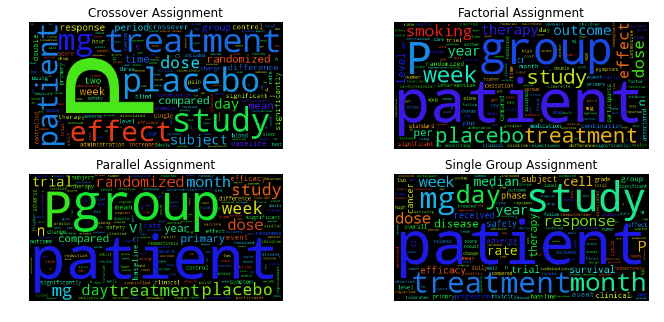

In [4]:
from support import word_cloud

fig = plt.figure(figsize=(12, 5))
plt.clf()

for i, label in enumerate(np.sort(df.intervention_model.unique()), start=1):
    axes = fig.add_subplot(2, 2, i)
    words = ' '.join(df[df.intervention_model == label].abstract)
    
    word_cloud(words, axes, label)
    
plt.axis('off')
plt.show()

### Train Test Split

In [5]:
from sklearn.cross_validation import train_test_split

abstracts_train, abstracts_test, ys_train, ys_test = train_test_split(df.abstract, df.intervention_model)

abstracts_train.shape, abstracts_test.shape, ys_train.shape, ys_test.shape

((1563,), (522,), (1563,), (522,))

### Vectorize Train and Test Abstracts

Make sure to only fit the training set and **not** the test set!

In [6]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(ngram_range=(1, 2), stop_words='english')
vectorizer.fit(abstracts_train)

X_train, X_test = vectorizer.transform(abstracts_train), vectorizer.transform(abstracts_test)

X_train.shape

(1563, 169905)

### Extract and Order Vocabulary

In [7]:
import operator

vocabulary = [word for word, index in sorted(vectorizer.vocabulary_.items(), key=operator.itemgetter(1))]

### Hyperparameters

In [8]:
from sklearn.linear_model import SGDClassifier
from sklearn.grid_search import GridSearchCV

M, N = X_train.shape
K = 5 # number of folds for cross-validation

# a priori best hyperparameters
default_alpha = 0.001
default_n_iter = int(np.ceil(10**6/(M-M/K))) # http://scikit-learn.org/stable/modules/sgd.html#tips-on-practical-use

def search_params(clf, parameters, verbose=3, scoring='f1_macro', k=5, X_train=abstracts_train, ys_train=ys_train):
    """Perform a grid search over the parameters
    
    k: the number of folds to be used for cross-validation
    
    """
    grid_search = GridSearchCV(clf, parameters, verbose=verbose, scoring=scoring, cv=k)
    grid_search.fit(X_train, ys_train)
    
    return grid_search

def plot_hyperparam_performance(grid_search, hyperparam):
    """Plots performance over a hyperparameter set"""
    
    # Get scores for different hyperparam settings into dataframe
    df = pd.DataFrame(grid_search.grid_scores_, columns=grid_search.grid_scores_[0]._fields)
    
    # Explode cv scores for each hyperparam setting
    scores = df.cv_validation_scores.apply(pd.Series)
    scores = scores.rename(columns=lambda x: 's{}'.format(x))
    score_columns = scores.columns
    
    scores['f1'], scores['err'] = scores.mean(axis=1), scores.std(axis=1) # mean f1 and stddev for cv scores
    
    # Put hyperparam values into a dataframe
    hyperparams = df.parameters.apply(lambda x: pd.Series(x[hyperparam]))
    hyperparams = hyperparams.rename(columns={0: hyperparam})
    
    df = pd.concat([hyperparams, scores], axis=1) # concatenate the two back together

    # Plot f1 and all the scores for each hyperparam setting
    axes = df['f1'].plot(yerr=df.err, linewidth=.5)
    for s in score_columns:
        axes = df[s].plot(ax=axes, style='.', c='black')
        
    # Fix axes
    axes.set_xticklabels(df[hyperparam].tolist())
    axes.set_xticks(np.arange(0, len(df)))
    axes.set_xlim(min(df.index)-1, max(df.index+1))
    axes.set_xlabel(hyperparam)
    axes.set_ylabel('f1')

### Tune `TF-IDF`

In [9]:
from sklearn.pipeline import Pipeline

pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(ngram_range=(1, 2), stop_words='english')),
    ('clf', SGDClassifier(alpha=default_alpha, class_weight='auto', n_iter=default_n_iter)),
])

parameters = {
    'tfidf__binary': (False, True)
}

grid_search = search_params(pipeline, parameters, k=K)

plot_hyperparam_performance(grid_search, 'tfidf__binary')

Fitting 5 folds for each of 2 candidates, totalling 10 fits
[CV] tfidf__binary=False .............................................
[CV] .................... tfidf__binary=False, score=0.522769 -   4.1s
[CV] tfidf__binary=False .............................................
[CV] .................... tfidf__binary=False, score=0.574441 -   4.1s
[CV] tfidf__binary=False .............................................
[CV] .................... tfidf__binary=False, score=0.567063 -   4.1s
[CV] tfidf__binary=False .............................................
[CV] .................... tfidf__binary=False, score=0.548857 -   4.1s
[CV] tfidf__binary=False .............................................
[CV] .................... tfidf__binary=False, score=0.541898 -   4.1s
[CV] tfidf__binary=True ..............................................
[CV] ..................... tfidf__binary=True, score=0.558617 -   4.1s
[CV] tfidf__binary=True ..............................................
[CV] ............

[Parallel(n_jobs=1)]: Done   1 jobs       | elapsed:    4.1s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   41.0s finished


In [12]:
best_tfidf = grid_search.best_estimator_.named_steps['tfidf']

best_tfidf.binary, grid_search.best_score_

(True, 0.59894964642166537)

### Re-vectorize Training Set with Best `TF-IDF`

In [13]:
X_train = best_tfidf.transform(abstracts_train)

### Tune `alpha`

Fitting 5 folds for each of 7 candidates, totalling 35 fits
[CV] alpha=0.1 .......................................................
[CV] .............................. alpha=0.1, score=0.198077 -   4.1s
[CV] alpha=0.1 .......................................................
[CV] .............................. alpha=0.1, score=0.198077 -   4.0s
[CV] alpha=0.1 .......................................................
[CV] .............................. alpha=0.1, score=0.198459 -   4.0s
[CV] alpha=0.1 .......................................................
[CV] .............................. alpha=0.1, score=0.199226 -   4.1s
[CV] alpha=0.1 .......................................................
[CV] .............................. alpha=0.1, score=0.199226 -   4.0s
[CV] alpha=0.01 ......................................................
[CV] ............................. alpha=0.01, score=0.547759 -   3.4s
[CV] alpha=0.01 ......................................................
[CV] ............

/home/ebanner/.anaconda/envs/py27/lib/python2.7/site-packages/sklearn/metrics/classification.py:958: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
[Parallel(n_jobs=1)]: Done   1 jobs       | elapsed:    4.1s
[Parallel(n_jobs=1)]: Done  32 jobs       | elapsed:  1.8min



[CV] alpha=1e-07 .....................................................
[CV] ............................ alpha=1e-07, score=0.554435 -   2.9s
[CV] alpha=1e-07 .....................................................
[CV] ............................ alpha=1e-07, score=0.552816 -   2.9s
[CV] alpha=1e-07 .....................................................
[CV] ............................ alpha=1e-07, score=0.549805 -   2.8s


[Parallel(n_jobs=1)]: Done  35 out of  35 | elapsed:  1.9min finished


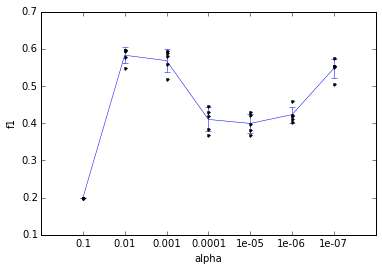

In [14]:
alphas = [{'alpha': np.logspace(-1, -7, 7)}]

clf = SGDClassifier(class_weight='auto', n_iter=default_n_iter)

grid_search = search_params(clf, alphas, k=K, X_train=X_train, ys_train=ys_train)

plot_hyperparam_performance(grid_search, 'alpha')

In [15]:
best_alpha = grid_search.best_estimator_.alpha

best_alpha, grid_search.best_score_

(0.01, 0.58271017607432096)

### Tune `n_iter`

Fitting 5 folds for each of 7 candidates, totalling 35 fits
[CV] n_iter=5 ........................................................
[CV] ............................... n_iter=5, score=0.393480 -   0.0s
[CV] n_iter=5 ........................................................
[CV] ............................... n_iter=5, score=0.490216 -   0.0s
[CV] n_iter=5 ........................................................
[CV] ............................... n_iter=5, score=0.524114 -   0.0s
[CV] n_iter=5 ........................................................
[CV] ............................... n_iter=5, score=0.526184 -   0.0s
[CV] n_iter=5 ........................................................
[CV] ............................... n_iter=5, score=0.417436 -   0.0s
[CV] n_iter=10 .......................................................
[CV] .............................. n_iter=10, score=0.501041 -   0.1s
[CV] n_iter=10 .......................................................
[CV] ............

[Parallel(n_jobs=1)]: Done   1 jobs       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  32 jobs       | elapsed:  1.4min



[CV] n_iter=2000 .....................................................
[CV] ............................ n_iter=2000, score=0.596910 -   8.8s
[CV] n_iter=2000 .....................................................
[CV] ............................ n_iter=2000, score=0.577099 -   8.8s
[CV] n_iter=2000 .....................................................
[CV] ............................ n_iter=2000, score=0.598088 -   8.3s


[Parallel(n_jobs=1)]: Done  35 out of  35 | elapsed:  1.8min finished


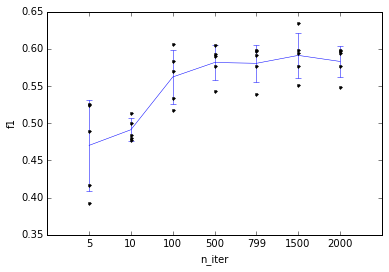

In [16]:
n_iters = [{'n_iter': [5, 10, 100, 500, default_n_iter, 1500, 2000]}]

clf = SGDClassifier(alpha=best_alpha, class_weight='auto')

grid_search = search_params(clf, n_iters, k=K, X_train=X_train, ys_train=ys_train)

plot_hyperparam_performance(grid_search, 'n_iter')

In [17]:
best_n_iter = grid_search.best_estimator_.n_iter

best_n_iter, grid_search.best_score_

(1500, 0.59124891974089089)

### Best `(clf, tf-idf)` Pair

In [18]:
best_clf = grid_search.best_estimator_

best_clf

SGDClassifier(alpha=0.01, average=False, class_weight='auto', epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', n_iter=1500, n_jobs=1,
       penalty='l2', power_t=0.5, random_state=None, shuffle=True,
       verbose=0, warm_start=False)

In [19]:
best_tfidf

TfidfVectorizer(analyzer=u'word', binary=True, decode_error=u'strict',
        dtype=<type 'numpy.int64'>, encoding=u'utf-8', input=u'content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 2), norm=u'l2', preprocessor=None, smooth_idf=True,
        stop_words='english', strip_accents=None, sublinear_tf=False,
        token_pattern=u'(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
        vocabulary=None)

### Prediction on Test Set

In [20]:
# Vectorize test set with best TF-IDF and predict with best clf
X_test = best_tfidf.transform(abstracts_test)
predictions = best_clf.predict(X_test)

# Compute f1s for all classes
import sklearn
lb = sklearn.preprocessing.LabelBinarizer()
f1s = sklearn.metrics.f1_score(lb.fit_transform(ys_test), lb.fit_transform(predictions), average=None)

# Display f1s
import re
from collections import namedtuple
Classes = namedtuple('Classes', map(lambda s: re.sub('\s+', '_', s), best_clf.classes_))

print 'f1s: {}'.format({label: f1 for label, f1 in zip(best_clf.classes_, f1s)})
print
print 'Average: {}'.format(np.mean(f1s))

f1s: {'Factorial Assignment': 0.18181818181818182, 'Parallel Assignment': 0.85341074020319319, 'Crossover Assignment': 0.64102564102564097, 'Single Group Assignment': 0.72131147540983609}

Average: 0.599391509614


### Confusion Matrix

#### Observations

- Crossover assignment is often confused as parallel assignment. This makes sense as there are multiple groups, just as in parallel assignment
- Factorial assignment f1 is very low because we just don't have enough data for them. In the word clouds below, you can see *adhd* as being the most strongly correlated unigram with factorial assignments, instead of *combination*, which makes more sense
- Parallel assignment is often classified correctly. The model confuses parallel and single groups

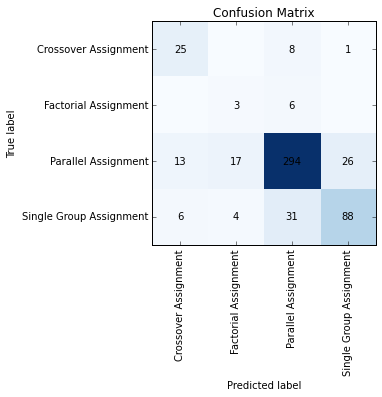

In [21]:
confusion_matrix = sklearn.metrics.confusion_matrix(ys_test, predictions)

fig = plt.figure()
plt.clf()

labels = best_clf.classes_

plt.imshow(confusion_matrix, cmap=plt.cm.Blues, interpolation='nearest')
plt.title('Confusion Matrix')
tick_marks = np.arange(len(labels))
plt.xticks(tick_marks, labels, rotation=90)
plt.yticks(tick_marks, labels)
plt.ylabel('True label')
plt.xlabel('Predicted label')

width = height = len(labels)

for x in xrange(width):
    for y in xrange(height):
        plt.annotate(str(confusion_matrix[x][y]) if confusion_matrix[x][y] else '', xy=(y, x), 
                    horizontalalignment='center',
                    verticalalignment='center')

### Features with Highest Coefficients

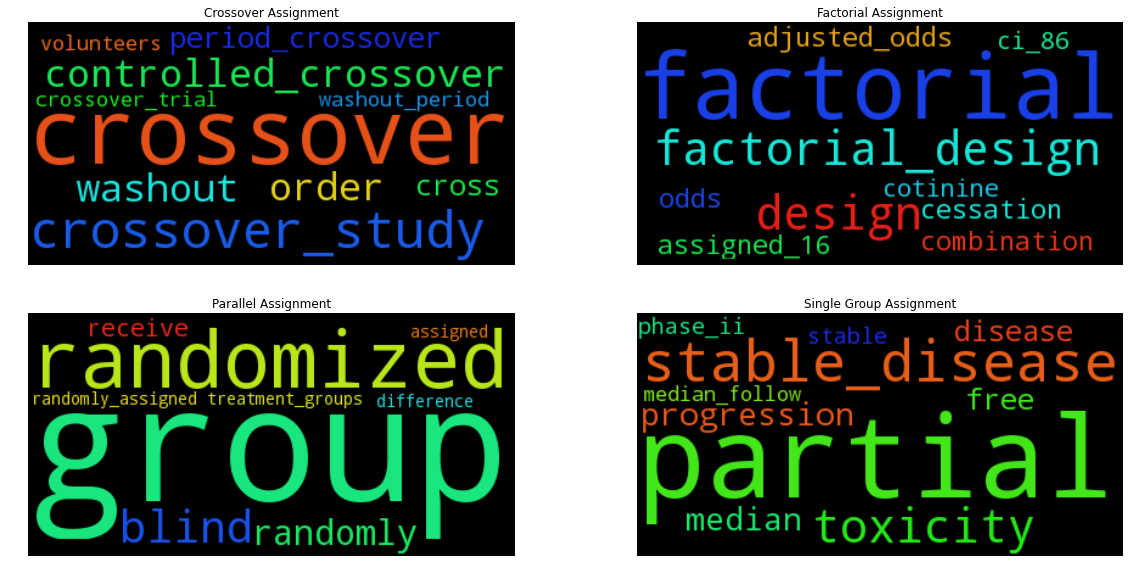

In [22]:
import re

fig = plt.figure(figsize=(20, 20))
plt.clf()

for i, (weights, title) in enumerate(zip(best_clf.coef_, labels), start=1):
    pairs = sorted(zip(weights, vocabulary), reverse=True)[:10]
    pairs = [(pair[0], re.sub('\s+', '_', pair[1])) for pair in pairs]
    
    def duplicate_words(pairs):
        """Yields words duplicated proportional to their corresponding coefficients"""
        
        for coef, word in pairs:
            for _ in range(int(coef*100)):
                yield word
            
    duped_words = list(duplicate_words(pairs))
    
    axes = fig.add_subplot(4, 2, i)
    word_cloud(' '.join(duped_words), axes, title)
    
plt.axis('off')
plt.show()